<a href="https://colab.research.google.com/github/sauravsingla/General/blob/master/Customer_RFM_Visualisation_Price_Elasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install pyseoanalyzer

In [ ]:
!wget https://archive.ics.uci.edu/ml/datasets/Online+Retail

In [ ]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

In [ ]:
sales = pd.read_excel('Online Retail.xlsx')
sales.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [ ]:
print('{:,} rows; {:,} columns'.format(sales.shape[0], sales.shape[1]))

541,909 rows; 8 columns


In [ ]:
print('{:,} invoices don\'t have a customer id'.format(sales[sales.CustomerID.isnull()].shape[0]))

135,080 invoices don't have a customer id


In [ ]:
sales.dropna(subset=['CustomerID'], inplace=True)

In [ ]:
print('Orders from {} to {}'.format(sales['InvoiceDate'].min(),
                                    sales['InvoiceDate'].max()))

Orders from 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [ ]:
sales['Price'] = sales['Quantity'] * sales['UnitPrice']

In [ ]:
sales['InvoiceNo'].value_counts().head()

576339    542
579196    533
580727    529
578270    442
573576    435
Name: InvoiceNo, dtype: int64

In [ ]:
orders = sales.groupby(['InvoiceNo', 'InvoiceDate', 'CustomerID']).agg({'Price': lambda x: x.sum()}).reset_index()
orders.head()

,InvoiceNo,InvoiceDate,CustomerID,Price
0,536365,2010-12-01 08:26:00,17850.0,139.12
1,536366,2010-12-01 08:28:00,17850.0,22.20
2,536367,2010-12-01 08:34:00,13047.0,278.73
3,536368,2010-12-01 08:34:00,13047.0,70.05
4,536369,2010-12-01 08:35:00,13047.0,17.85


In [ ]:
NOW = orders['InvoiceDate'].max() + timedelta(days=1)
NOW

Timestamp('2011-12-10 12:50:00')

In [ ]:

period = 365

In [ ]:
orders['DaysSinceOrder'] = orders['InvoiceDate'].apply(lambda x: (NOW - x).days)

In [ ]:
aggr = {
    'DaysSinceOrder': lambda x: x.min(),  # the number of days since last order (Recency)
    'InvoiceDate': lambda x: len([d for d in x if d >= NOW - timedelta(days=period)]), # the total number of orders in the last period (Frequency)
}
rfm = orders.groupby('CustomerID').agg(aggr).reset_index()
rfm.rename(columns={'DaysSinceOrder': 'Recency', 'InvoiceDate': 'Frequency'}, inplace=True)
rfm.head()

,CustomerID,Recency,Frequency
0,12346.0,326,2
1,12347.0,2,6
2,12348.0,75,4
3,12349.0,19,1
4,12350.0,310,1


In [ ]:
rfm['Monetary'] = rfm['CustomerID'].apply(lambda x: orders[(orders['CustomerID'] == x) & \
                                                           (orders['InvoiceDate'] >= NOW - timedelta(days=period))]\
                                                           ['Price'].sum())
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,6,3598.21
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [ ]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Frequency': {0.2: 1.0, 0.4: 2.0, 0.6: 3.0, 0.8: 6.0},
 'Monetary': {0.2: 215.89800000000002,
  0.4: 440.432,
  0.6: 876.3679999999999,
  0.8: 1909.6580000000006},
 'Recency': {0.2: 11.0, 0.4: 32.0, 0.6: 71.0, 0.8: 178.80000000000018}}

In [ ]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1
    
def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5    

In [ ]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [ ]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM Score
0,12346.0,326,2,0.00,1,2,1,121
1,12347.0,2,6,3598.21,5,4,5,545
2,12348.0,75,4,1797.24,2,4,4,244
3,12349.0,19,1,1757.55,4,1,4,414
4,12350.0,310,1,334.40,1,1,2,112


In [ ]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
0,12346.0,326,2,0.00,1,2,1,121,hibernating
1,12347.0,2,6,3598.21,5,4,5,545,champions
2,12348.0,75,4,1797.24,2,4,4,244,at risk
3,12349.0,19,1,1757.55,4,1,4,414,promising
4,12350.0,310,1,334.40,1,1,2,112,hibernating


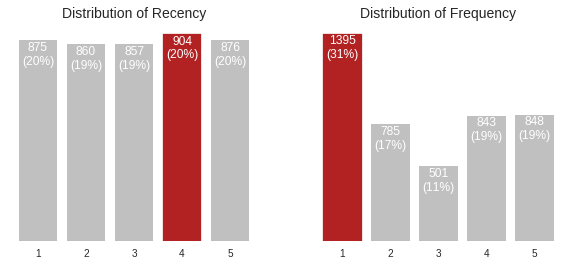

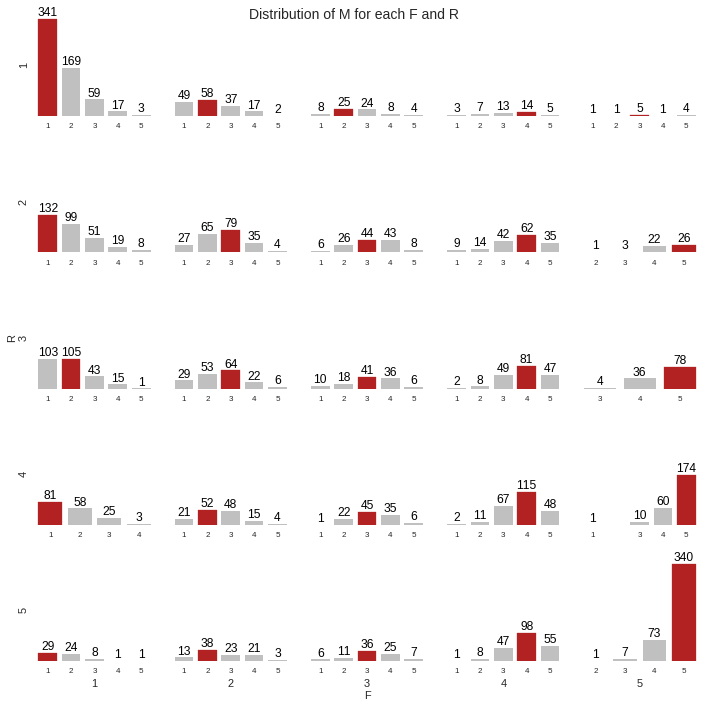

In [ ]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')
        
plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

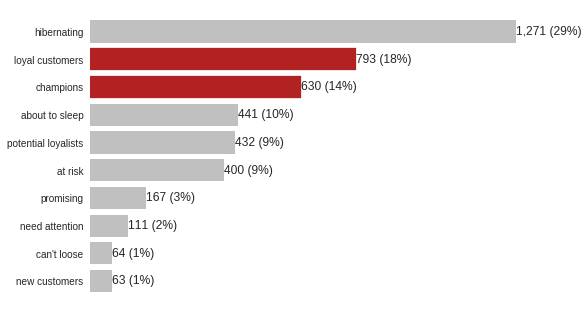

In [ ]:
# count the number of customers in each segment
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

In [ ]:
%matplotlib inline
from __future__ import print_function
from statsmodels.compat import lzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
beef = pd.read_csv('beef.csv')
beef.head(10)

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,Year,Quarter,Quantity,Price
0,1977,1,22.9976,142.1667
1,1977,2,22.6131,143.9333
2,1977,3,23.4054,146.5000
3,1977,4,22.7401,150.8000
4,1978,1,22.0441,160.0000
5,1978,2,21.7602,182.5333
6,1978,3,21.6064,186.2000
7,1978,4,21.8814,186.4333
8,1979,1,20.5086,211.7000
9,1979,2,19.0408,231.5000


In [ ]:
beef_model = ols("Quantity ~ Price", data=beef).fit()
print(beef_model.summary())

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     811.2
Date:                Fri, 18 Jan 2019   Prob (F-statistic):           1.69e-46
Time:                        20:29:26   Log-Likelihood:                -77.493
No. Observations:                  91   AIC:                             159.0
Df Residuals:                      89   BIC:                             164.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.0515      0.413     72.701      0.0

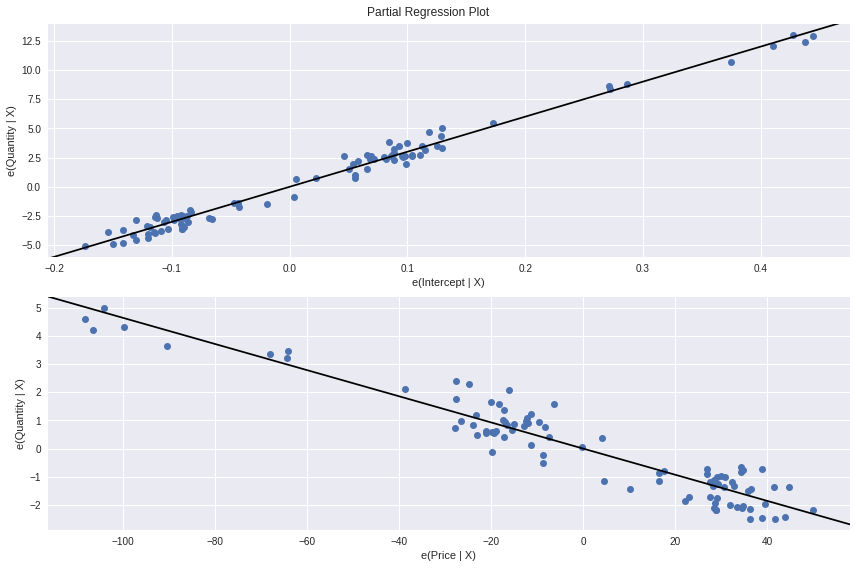

In [ ]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(beef_model, fig=fig)

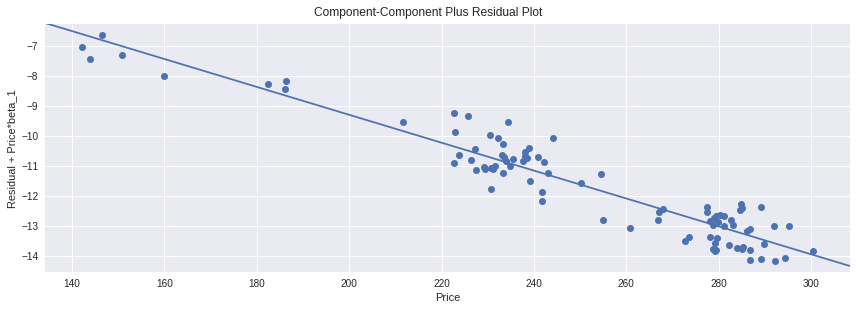

In [ ]:
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_ccpr_grid(beef_model, fig=fig)

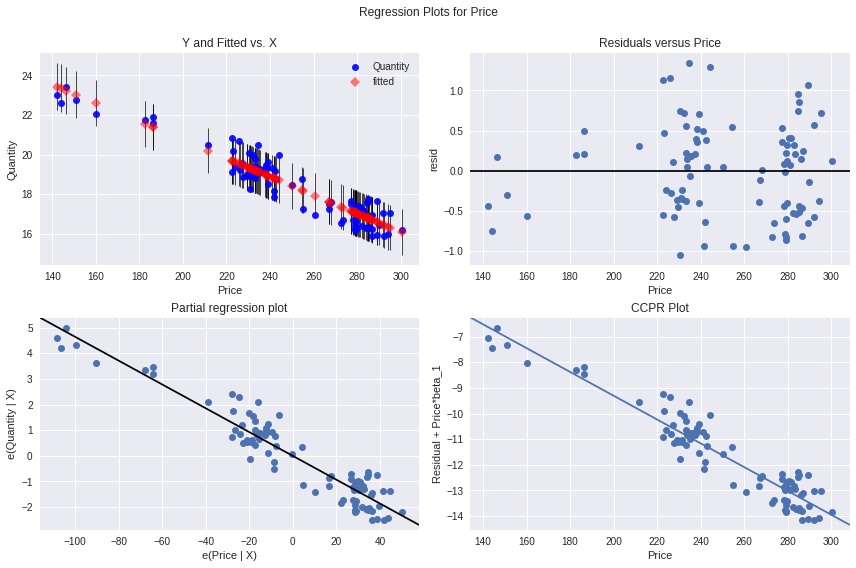

In [ ]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(beef_model, 'Price', fig=fig)

In [ ]:
beef['Year'] = pd.to_datetime(beef['Year'], format="%Y")
from pandas.tseries.offsets import *
beef['Date'] = beef.apply(lambda x:(x['Year'] + BQuarterBegin(x['Quarter'])), axis=1)
beef.drop(['Year', 'Quarter'], axis=1, inplace=True)
beef.set_index('Date', inplace=True)
beef.head(10)

,Quantity,Price
Date,,
1977-03-01,22.9976,142.1667
1977-06-01,22.6131,143.9333
1977-09-01,23.4054,146.5000
1977-12-01,22.7401,150.8000
1978-03-01,22.0441,160.0000
1978-06-01,21.7602,182.5333
1978-09-01,21.6064,186.2000
1978-12-01,21.8814,186.4333
1979-03-01,20.5086,211.7000


In [ ]:
endog = beef['Quantity']
exog = sm.add_constant(beef['Price'])
mod = sm.RecursiveLS(endog, exog)
res = mod.fit()
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:               Quantity   No. Observations:                   91
Model:                    RecursiveLS   Log Likelihood                 -84.326
Date:                Fri, 18 Jan 2019   AIC                            172.653
Time:                        20:31:01   BIC                            177.675
Sample:                    03-01-1977   HQIC                           174.679
                         - 09-01-1999                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.0515      0.413     72.701      0.000      29.241      30.862
Price         -0.0465      0.002    -28.482      0.000      -0.050      -0.043
Ljung-Box (Q):                      422.30   Jarque-

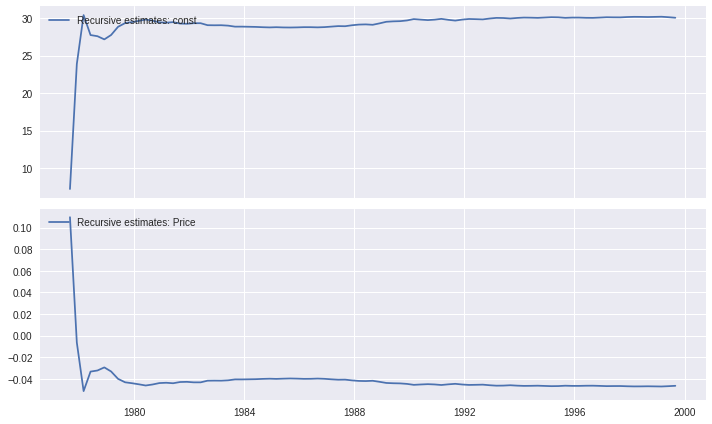

In [ ]:
res.plot_recursive_coefficient(range(mod.k_exog), alpha=None, figsize=(10,6));

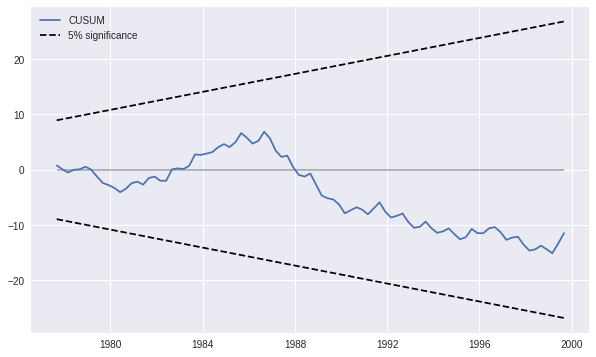

In [ ]:
fig = res.plot_cusum(figsize=(10,6));